In [1]:
from platform import python_version
import os

print(f"Python version: {python_version()}")

try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except:
    print("TensorFlow not found")

try:
    import numpy as np
    print(f"Numpy version: {np.__version__}")
except:
    print("Numpy not found")

try:
    import pandas as pd
    print(f"Pandas version: {pd.__version__}")
except:
    print("Pandas not found")

Python version: 3.10.16
TensorFlow version: 2.11.0
Numpy version: 1.26.4
Pandas version: 2.2.3


## Load CBIS-DDSM dataset

In [2]:
from definitions import *

print(f"Dataset path: {data_root}")
print(f"Meta path: {meta_path}")
print(f"Mass training data path: {mass_train_path}")
print(f"Mass test data path: {mass_test_path}")

Dataset path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688
Meta path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\metadata.csv
Mass training data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\mass_case_description_train_set.csv
Mass test data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\mass_case_description_test_set.csv


In [3]:
df_meta = pd.read_csv(meta_path)
df_meta.head(3)

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.9590.100.1.2.374115997511889073021...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_CC,1.3.6.1.4.1.9590.100.1.2.859354343102033567126...,NaN,08-29-2017,full mammogram images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,1,27.84 MB,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-20...,2025-05-24T22:44:39.334
1,1.3.6.1.4.1.9590.100.1.2.174390361112646747718...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_MLO,1.3.6.1.4.1.9590.100.1.2.384159464510350889125...,NaN,08-29-2017,full mammogram images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,1,28.97 MB,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_MLO\08-29-2...,2025-05-24T22:44:43.456
2,1.3.6.1.4.1.9590.100.1.2.188613955710170417803...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_MLO_1,1.3.6.1.4.1.9590.100.1.2.291121996131431385353...,NaN,08-29-2017,ROI mask images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,2,14.62 MB,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_MLO_1\08-29...,2025-05-24T22:44:44.687


In [4]:
if False:
    df_dicom = pd.read_csv(r'C:\Users\lejam\Desktop\CBIS-DDSM\manifest-ZkhPvrLo5216730872708713142\dicom_info.csv')
    df_dicom.head(3)
    
    # Check image types
    img_types = df_dicom.SeriesDescription.unique()
    print(f"Image types: {img_types}")
    
    img_paths = {}
    for type in img_types:
        if pd.isnull(type): continue
        img_paths[type] = df_dicom[df_dicom.SeriesDescription==type].image_path
    print(f"Image paths have been updated for each image type: {list(img_paths.keys())}")

    # Update image paths with the correct directory
    correct_dir = r'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'
    for key in img_paths:
        if len(img_paths[key]) == 0: continue
        print(f"{key}")
        print(f"\toriginal: {img_paths[key].iloc[0]}")
        img_paths[key] = img_paths[key].replace('CBIS-DDSM/jpeg', correct_dir, regex=True)
        print(f"\tupdated: {img_paths[key].iloc[0]}")

    # Organise image paths
    img_path_dict = {}
    for key in img_paths:
        for val in img_paths[key]:
            key2 = val.split("/")[4]
            img_path_dict[key2] = val

## Mass Dataset

In [5]:
# Load mass datasets
mass_train = pd.read_csv(mass_train_path)
mass_test = pd.read_csv(mass_test_path)

In [6]:
# Check the size of both datasets
print(f"Training data: {mass_train.shape}")
print(f"Test data: {mass_test.shape}")

Training data: (1318, 14)
Test data: (378, 14)


### Training data

In [7]:
mass_train.head(3)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...


In [8]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [9]:
# Check for null values
mass_train.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [10]:
# Fill missing values using backwards fill
mass_train['mass shape'] = mass_train['mass shape'].bfill()
mass_train['mass margins'] = mass_train['mass margins'].bfill()

# Re-check the number of missing values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left or right breast       0
image view                 0
abnormality id             0
abnormality type           0
mass shape                 0
mass margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [11]:
# Get a quantitative overview of each feature
mass_train.describe()

,breast_density,abnormality id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


### Test data

In [12]:
mass_test.head(3)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...


In [13]:
# Check for null values
mass_test.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [14]:
# Fill missing values using backwards fill
mass_test['mass margins'] = mass_test['mass margins'].bfill()

# Re-check the number of missing values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left or right breast       0
image view                 0
abnormality id             0
abnormality type           0
mass shape                 0
mass margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

### Visualisation

In [15]:
import matplotlib.pyplot as plt

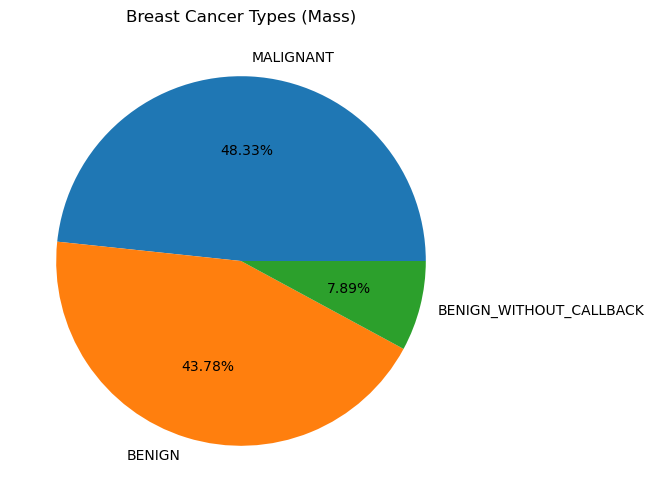

In [17]:
# Pathology distributions
value = mass_train['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.2f%%')
plt.title('Breast Cancer Types (Mass)', fontsize=12)
plt.show()

### Display Sample Images

In [18]:
import glob
import pydicom

##### Use original image paths

In [19]:
def render_without_filters(column, number):
    # Set up figure
    rows = 1
    cols = number
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    
    # loop through images for display
    for index, row in mass_train.head(number).iterrows():
        # Validate the file path
        splitted_path = row[column].split('/')
        if len(splitted_path) == 0: continue

        # Check if the DICOM data exists
        subject_id = splitted_path[0]
        meta_data = df_meta[df_meta['Subject ID']==subject_id]
        if meta_data.shape[0] == 0: continue

        # Display DICOM (.dcm) files
        image_dir = meta_data.iloc[0]['File Location']
        path = os.path.join(data_root, image_dir[2:], "*")
        for image_path in glob.glob(path):
            # Parse each DICOM file
            ds = pydicom.dcmread(image_path)

            # Render the image on the current axis
            ax = axes[index]
            ax.imshow(ds.pixel_array, cmap='gray')
            ax.set_title(f"{row['pathology']}")
            ax.axis('off')
    # Display the subplot
    plt.tight_layout()
    plt.show()

Full Mammograms:



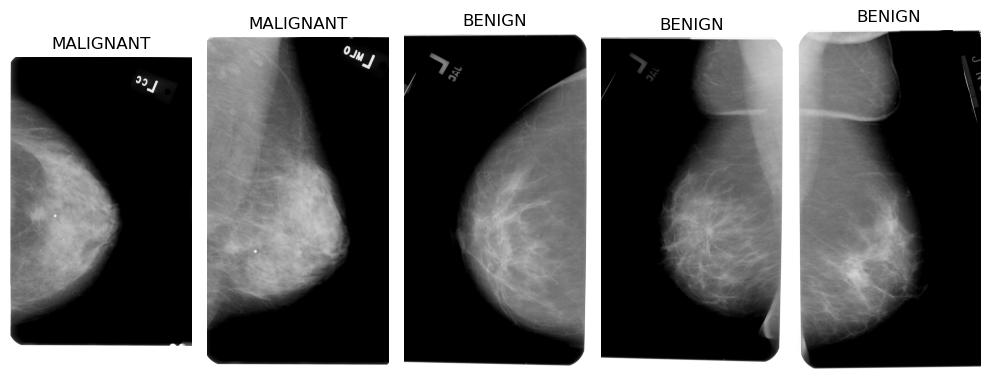

In [20]:
print('Full Mammograms:\n')
render_without_filters('image file path', 5)

Cropped Mammograms:



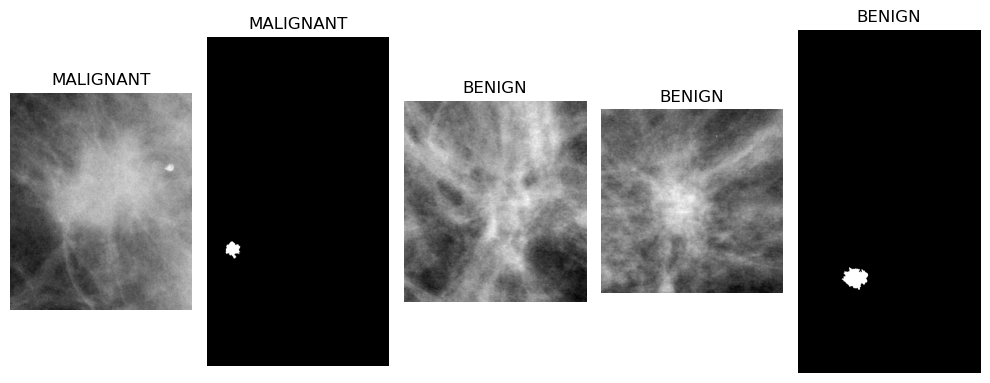

In [21]:
print('Cropped Mammograms:\n')
render_without_filters('cropped image file path', 5)

Due to incorrect labelling, some ROI mask images were displayed instead of the cropped images. ROI mask and cropped images should be stored in separate folders to avoid confusion. However, in some cases, they were stored in the same folder with identical labels.

To resolve this issue, the distinct characteristics of ROI mask images were used, as described below. ROI mask images contain only two pixel values: 0 and 255 (black and white). If an image contains only these two values, it is labeled as an ROI mask image; otherwise, it is considered a cropped image.

##### Use updated image paths

In [22]:
def render_with_filters(column, number):
    # Set up figure
    rows = 1
    cols = number
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    
    # loop through images for display
    for index, row in mass_train.head(number).iterrows():
        # Validate the file path
        splitted_path = row[column].split('/')
        if len(splitted_path) == 0: continue

        # Check if the DICOM data exists
        subject_id = splitted_path[0]
        meta_data = df_meta[df_meta['Subject ID']==subject_id]
        if meta_data.shape[0] == 0: continue

        # Display DICOM (.dcm) files
        image_dir = meta_data.iloc[0]['File Location']
        path = os.path.join(data_root, image_dir[2:], "*")
        for image_path in glob.glob(path):
            # Parse each DICOM file
            ds = pydicom.dcmread(image_path)

            # Categorise the file as either a cropped image or an ROI mask
            # ROI mask files contain only two pixel values: 0 (background) and 255 (region of interest)
            diff = np.setdiff1d(np.unique(ds.pixel_array), np.array([0, 255]))
            if column == 'cropped image file path' and diff.size == 0: continue
            if column == 'ROI mask file path' and diff.size > 0: continue

            # Render the image on the current axis
            ax = axes[index]
            ax.imshow(ds.pixel_array, cmap='gray')
            ax.set_title(f"{row['pathology']}")
            ax.axis('off')
    # Display the subplot
    plt.tight_layout()
    plt.show()

Full Mammograms:



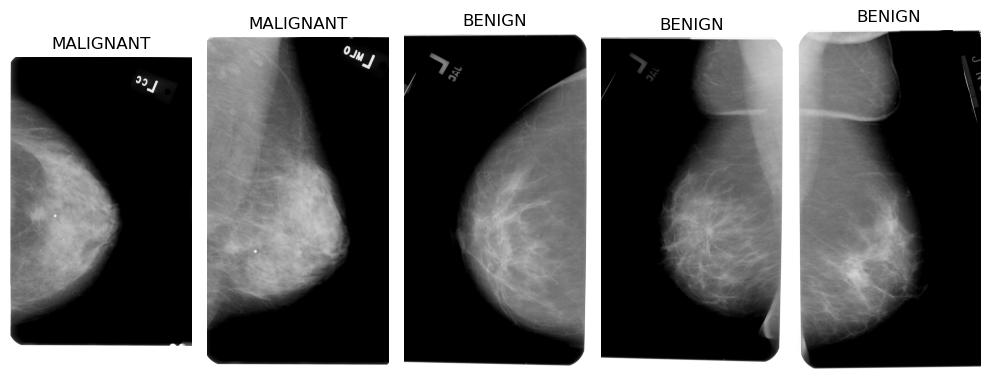

In [23]:
print('Full Mammograms:\n')
render_with_filters('image file path', 5)

Cropped Mammograms:



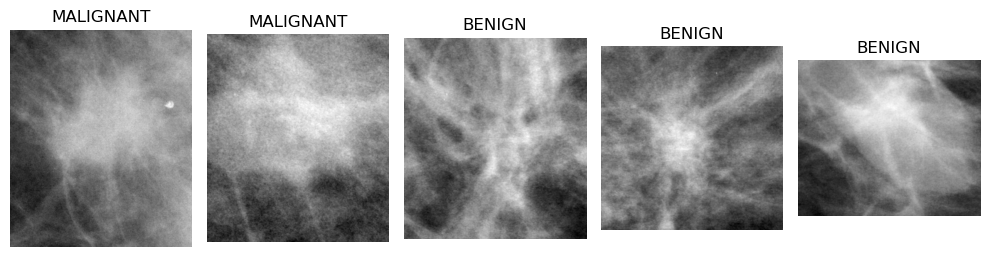

In [24]:
print('Cropped Mammograms:\n')
render_with_filters('cropped image file path', 5)

ROI Mask:



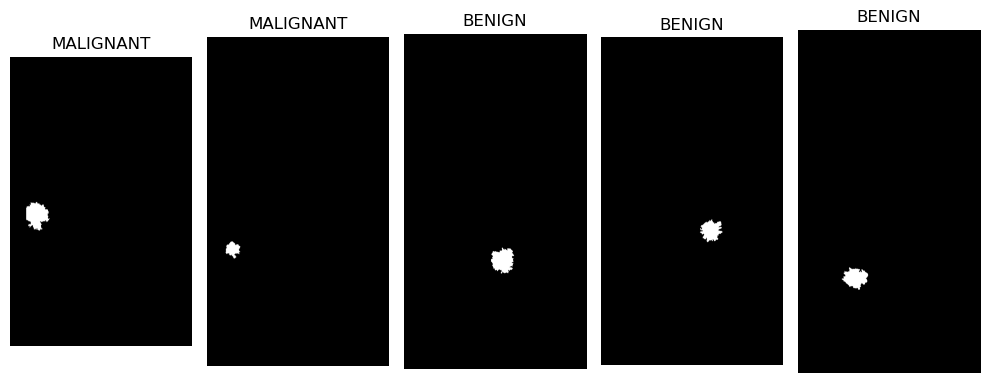

In [25]:
print('ROI Mask:\n')
render_with_filters('ROI mask file path', 5)

With the revised function, the cropped images are now correctly displayed without being mixed with ROI mask images. Similarly, the ROI mask images are also correctly identified and displayed.